In [4]:
import cfbd
import numpy as np
import pandas as pd
import openpyxl

from api_key import API_KEY
from fastai.tabular import *
from fastai.tabular.all import *

configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = API_KEY

api_config = cfbd.ApiClient(configuration)

teams_api = cfbd.TeamsApi(api_config)
ratings_api = cfbd.RatingsApi(api_config)
games_api = cfbd.GamesApi(api_config)
stats_api = cfbd.StatsApi(api_config)
betting_api = cfbd.BettingApi(api_config)

games = []
lines = []

for year in range(2015, 2022):
    response = games_api.get_games(year=year)
    games = [*games, *response]

    response = betting_api.get_lines(year=year)
    lines = [*lines, *response]

games = [g for g in games if g.home_conference is not None and g.away_conference is not None and g.home_points is not None and g.away_points is not None]

In [5]:
games = [
    dict(
        id = g.id,
        year = g.season,
        week = g.week,
        neutral_site = g.neutral_site,
        home_team = g.home_team,
        home_conference = g.home_conference,
        home_points = g.home_points,
        home_elo = g.home_pregame_elo,
        away_team = g.away_team,
        away_conference = g.away_conference,
        away_points = g.away_points,
        away_elo = g.away_pregame_elo
    ) for g in games]


In [6]:
for game in games:
    game_lines = [l for l in lines if l.id == game['id']]

    if len(game_lines) > 0:
        game_line = [l for l in game_lines[0].lines if l['provider'] == 'Bovada']

        if len(game_line) > 0 and game_line[0]['spread'] is not None:
            game['spread'] = float(game_line[0]['spread'])
        if len(game_line) > 0 and game_line[0]['overUnder'] is not None:
            game['overUnder'] = float(game_line[0]['overUnder'])

In [7]:
games = [g for g in games if 'spread' in g and g['spread'] is not None]
games = [g for g in games if 'overUnder' in g and g['overUnder'] is not None]

len(games)

1456

In [8]:
for game in games:
    game['margin'] = game['away_points'] - game['home_points']
    game['total'] = game['away_points'] + game['home_points']

In [9]:
df = pd.DataFrame.from_records(games).dropna()
df.head()

,id,year,week,neutral_site,home_team,home_conference,home_points,home_elo,away_team,away_conference,away_points,away_elo,spread,overUnder,margin,total
0,401121960,2019,10,False,Appalachian State,Sun Belt,21,1770,Georgia Southern,Sun Belt,24,1396,-14.0,41.5,3,45
1,401112080,2019,10,False,Baylor,Big 12,17,1665,West Virginia,Big 12,14,1530,-18.0,57.0,-3,31
2,401117894,2019,10,False,Connecticut,American Athletic,10,996,Navy,American Athletic,56,1599,26.5,55.0,46,66
3,401112495,2019,10,False,Syracuse,ACC,27,1458,Boston College,ACC,58,1489,-3.0,59.0,31,85
4,401114352,2019,10,False,UMass,FBS Independents,21,832,Liberty,FBS Independents,63,1264,24.0,72.0,42,84


In [10]:
test_df = df.query("year == 2021")
train_df = df.query("year != 2021")

In [11]:
excluded = ['id','year','week','home_team','away_team','margin', 'total', 'home_points', 'away_points']
cat_features = ['home_conference','away_conference','neutral_site']
cont_features = [c for c in df.columns.to_list() if c not in cat_features and c not in excluded]

cont_features

['home_elo', 'away_elo', 'spread', 'overUnder']

In [12]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
splits

((#580) [182,519,12,144,209,642,3,605,84,530...],
 (#145) [661,202,456,659,105,364,496,259,305,648...])

In [13]:
to = TabularPandas(train_df, procs=[Categorify, Normalize],
                    y_names={"margin", "total"},
                    cat_names = cat_features,
                    cont_names = cont_features,
                   splits=splits)

In [71]:
dls = to.dataloaders(bs=64)
dls.show_batch()

,home_conference,away_conference,neutral_site,home_elo,away_elo,spread,overUnder,margin,total
0,SEC,SEC,False,1627.000002,1876.000004,14.000000,54.5,35.0,63.0
1,Big Ten,Big Ten,False,1847.000013,1442.000001,-20.000001,51.5,-38.0,52.0
2,Conference USA,Conference USA,False,1391.000006,1164.999989,-13.500000,45.5,3.0,59.0
3,Mountain West,Mountain West,False,1169.999995,1272.999999,7.000000,65.5,-3.0,73.0
4,Mid-American,Mid-American,False,916.000028,1355.000006,14.000000,55.5,31.0,45.0
5,Sun Belt,Sun Belt,False,1388.000006,1413.000000,-1.000000,52.0,-5.0,71.0
6,Pac-12,Pac-12,False,1639.000002,1599.999999,-11.000000,68.5,-25.0,51.0
7,SEC,SEC,False,1504.000000,1819.999985,14.000000,51.5,21.0,47.0
8,ACC,ACC,False,1513.000000,1528.000000,-1.000000,56.5,-7.0,61.0
9,Big Ten,Big Ten,False,1299.000007,1338.000007,-5.500000,51.5,3.0,43.0


In [15]:
learn = tabular_learner(dls, metrics=mae, lr=10e-1)

SuggestedLRs(valley=0.019054606556892395)

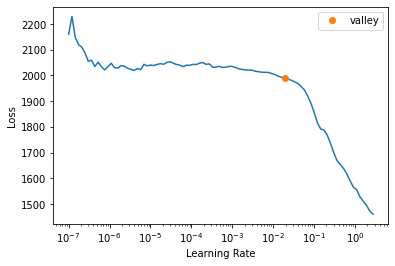

In [16]:
learn.lr_find()

In [17]:
learn = tabular_learner(dls, metrics=mae, lr=10e-2)
learn.fit(10)

epoch,train_loss,valid_loss,mae,time
0,1334.212402,346.128021,15.205886,00:02
1,830.261353,498.369720,17.823296,00:01
2,637.397217,298.062347,13.781591,00:01
3,521.908997,293.899200,13.674091,00:01
4,455.512543,268.573547,12.948856,00:01
5,405.585236,295.363525,13.497483,00:01
6,370.583405,278.095886,13.162575,00:01
7,345.050079,298.170563,13.730032,00:01
8,326.684998,286.501526,13.311981,00:01
9,311.137878,302.929138,13.683119,00:01


In [18]:
learn = tabular_learner(dls, metrics=mae, lr=10e-2)
learn.fit(5)

epoch,train_loss,valid_loss,mae,time
0,1330.504150,650.641113,20.214592,00:01
1,838.356628,405.833984,16.252869,00:01
2,652.263306,365.685669,15.257465,00:01
3,535.294250,319.410675,14.338691,00:01
4,464.483429,278.500702,13.366396,00:01


In [19]:
learn.show_results()

,home_conference,away_conference,neutral_site,home_elo,away_elo,spread,overUnder,margin,total,margin_pred,total_pred
0,8.0,8.0,1.0,-1.288405,-0.400592,1.458716,0.742599,7.0,47.0,14.673101,54.754311
1,4.0,4.0,1.0,1.687850,-0.115392,-0.676903,-0.418008,-6.0,46.0,-13.889623,52.250050
2,9.0,9.0,1.0,-0.893217,1.162307,1.003584,0.986937,12.0,26.0,13.237213,65.271469
3,1.0,1.0,1.0,0.345860,-0.514672,-0.046720,-1.334277,-18.0,58.0,-9.823806,54.426327
4,6.0,6.0,1.0,-2.848572,-0.917756,1.913847,1.903206,42.0,84.0,17.629402,82.850327
5,2.0,2.0,1.0,-1.090811,0.451207,0.583462,0.498261,17.0,59.0,6.172044,56.941189
6,1.0,1.0,1.0,0.403491,-0.594529,-0.186761,0.009584,-21.0,69.0,-12.299972,59.828377
7,8.0,8.0,1.0,-1.185491,-1.221970,0.653482,-0.906685,-14.0,68.0,2.702043,46.874317
8,11.0,5.0,1.0,-0.246921,0.561485,0.408411,-1.945122,-17.0,23.0,-0.050400,42.761093


In [107]:
pdf = test_df.copy()
pdf_orig = test_df.copy()
dl = learn.dls.test_dl(pdf)
pdf = learn.get_preds(dl=dl)[0].numpy()
pdf_orig.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [119]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None) 
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
#np.set_printoptions(threshold=sys.maxsize)
pred = pd.DataFrame(pdf)
#pred.to_excel("pred.xlsx")
pred.head(10)


,0,1
0,12.048593,49.790874
1,-29.071621,53.297894
2,-19.033604,57.595448
3,10.776255,58.341091
4,-8.192733,68.278587
5,-23.511600,54.203079
6,-13.970677,56.531364
7,19.895903,55.736568
8,-39.522114,51.540939
9,4.525865,66.160545


In [121]:
pdf_orig.join(pred)


,level_0,index,id,year,week,neutral_site,home_team,home_conference,home_points,home_elo,away_team,away_conference,away_points,away_elo,spread,overUnder,margin,total,0,1
0,0,725,401282714,2021,1,False,Illinois,Big Ten,30,1393,Nebraska,Big Ten,22,1503,7.0,52.0,-8,52,12.048593,49.790874
1,1,726,401286187,2021,1,False,Fresno State,Mountain West,45,1464,Connecticut,American Athletic,0,1223,-28.0,63.5,-45,45,-29.071621,53.297894
2,2,727,401309833,2021,1,False,UCLA,Pac-12,44,1517,Hawai'i,Mountain West,10,1466,-18.0,66.5,-34,54,-19.033604,57.595448
3,3,728,401282049,2021,1,False,New Mexico State,FBS Independents,3,1261,UTEP,Conference USA,30,1222,10.0,59.5,27,33,10.776255,58.341091
4,4,729,401300995,2021,1,False,UCF,American Athletic,36,1648,Boise State,Mountain West,31,1602,-6.5,67.5,-5,67,-8.192733,68.278587
5,5,730,401282607,2021,1,False,NC State,ACC,45,1459,South Florida,American Athletic,0,1251,-20.0,58.0,-45,45,-23.511600,54.203079
6,6,731,401300993,2021,1,False,Appalachian State,Sun Belt,33,1659,East Carolina,American Athletic,19,1403,-9.5,56.0,-14,52,-13.970677,56.531364
7,7,732,401282789,2021,1,False,Minnesota,Big Ten,31,1585,Ohio State,Big Ten,45,1905,14.0,61.5,14,76,19.895903,55.736568
8,8,733,401281952,2021,1,False,Tennessee,SEC,38,1489,Bowling Green,Mid-American,6,1041,-37.0,60.5,-32,44,-39.522114,51.540939
9,9,734,401309937,2021,1,False,Virginia Tech,ACC,17,1534,North Carolina,ACC,10,1724,6.0,63.5,-7,27,4.525865,66.160545


In [60]:
pdf.to_excel("output.xlsx")

AttributeError: 'numpy.ndarray' object has no attribute 'to_excel'

In [63]:
learn.export('cfbd_neural_net')

In [ ]:
learn = load_learner('cfbd_neural_net')